In [1]:
import os
import requests
import feedparser
from bs4 import BeautifulSoup
import json
def load_last_entry():
    if os.path.exists("last_entry.json"):
        with open("last_entry.json", 'r') as file:
            return json.load(file).get('last_entry_id', None)
    return None


In [2]:
def save_last_entry(entry_id):
    with open("last_entry.json", 'w') as file:
        json.dump({'last_entry_id': entry_id}, file)


In [3]:
from langchain_core.pydantic_v1  import BaseModel, AnyUrl,Field
from langchain_core.messages.human import HumanMessage
from typing import List

from datetime import datetime
class Mail_args(BaseModel):
    summarized_text:str   = Field(description="The summarized form of job posting")
    published :str=Field(description="date and time the job was published")

In [4]:
import smtplib
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText


from langchain_core.tools import tool

@tool("mail_tool", args_schema=Mail_args)
def send_email(summarized_text:str,published:str):
    """
    This tool will  help you send message to owner about the new job posting
    
    """
    from_email = ''
    from_password = ''
    
    # Create the email message
    msg = MIMEMultipart('alternative')
    msg['From'] = from_email
    msg['To'] = ""
    msg['Subject'] = "Upwork Job posting"
    html = f"""\
           <html>
             <head></head>
             <body>
               <p>Hello,<br>
                  Here is a job posting you might be interested in:<br>
                  <b>Published Date:</b>{published}<br>
                  <b>Description:</b> {summarized_text}<br>
               </p>
             </body>
           </html>
           """
    # Attach the email content as HTML
    msg.attach(MIMEText(html, 'html'))
    
    try:
        # Connect to the SMTP server
        server = smtplib.SMTP('smtp.gmail.com', 587)  # Replace with your SMTP server and port
        server.starttls()
        server.login(from_email, from_password)
        
        # Send the email
        server.send_message(msg)
        server.quit()
        return "Mail send to owner"
        
        
    except Exception as e:
        raise e





In [5]:
import json



def check_for_new_id(state):
    """
    Entry point to graph checks if new RSS entry has been added from last entry
    """
    message=state['messages']
    feed_url = 'https://www.upwork.com/ab/feed/topics/rss?securityToken=b02b265cc7370a516f799f0ad4322d3491cfc4c65c150e4bfd8bfbf76b64a7a9c200e84aaadb245e26951e0458fa14f3deb56524e7b5c6ffbf3f23489f7c7937&userUid=1648942861128376320&orgUid=1648942861128376321&topic=7610275'
    response = requests.get(feed_url)
    response.raise_for_status()
    feed = feedparser.parse(response.content)
    last_entry_id = load_last_entry()
    res=[]
    for entry in feed.entries:
        res.append(entry.id)
    latest_job_posting=res[0]
    if latest_job_posting==last_entry_id:
        return "end"
    else:
        return "clean_job_link_des" 
    
        
        
    


In [6]:
from typing import Annotated, Literal, Optional

from typing_extensions import TypedDict

from langgraph.graph.message import AnyMessage, add_messages


class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    job_descs :list[str]
    job_pubs:list[str]
    summarized_text:str
        
        
class Single_docs(TypedDict):
    job_desc:str
    job_pub:str
    

In [7]:
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_openai import ChatOpenAI
from langchain_groq import ChatGroq
from langgraph.prebuilt import ToolNode
all_tools=[send_email]

def agent(state:Single_docs):
    llm = ChatOpenAI(temperature=0,
    model="gpt-4o-mini")
    summarizer_prompt = ChatPromptTemplate.from_messages([
        (
            "system",
            "You will be given upwork job posting your job write the summary of the job posting and send the summarize version to the owner "
            "Always use the mail tool for sending email"
            "here is the job_description {job_description}"
            " and the time that it was published {pub}"
            ,
        ),
        ("placeholder", "{messages}"),
    ]
)
    assistant_runnable=summarizer_prompt|llm.bind_tools(all_tools)
    summarized_text=assistant_runnable.invoke({"messages": state["messages"],"job_description":state['job_desc'],"pub":state['job_pub']})
    return {
        "messages": summarized_text,
    }
    

In [8]:
from collections import defaultdict
# returns list of new jobs except the last entry
def clean_job_link_des(state:State):
    messages=state['messages']
    feed_url = 'https://www.upwork.com/ab/feed/topics/rss?securityToken=b02b265cc7370a516f799f0ad4322d3491cfc4c65c150e4bfd8bfbf76b64a7a9c200e84aaadb245e26951e0458fa14f3deb56524e7b5c6ffbf3f23489f7c7937&userUid=1648942861128376320&orgUid=1648942861128376321&topic=7610275'
    response = requests.get(feed_url)
    response.raise_for_status()
    feed = feedparser.parse(response.content)
    last_entry_id = load_last_entry()
    res=[]
    for entry in feed.entries:       
        if last_entry_id == entry.id:
            break
        else:
            res.append(entry)
    if res :
        last_entry_id=res[0]['link']
        save_last_entry(last_entry_id)
    cleaned_res=defaultdict(list)
    for  j in  res:
        soup = BeautifulSoup(j.description, 'html.parser')
        tags=['br','b']
        for br in soup.find_all(tags):
            br.decompose()
        entry_link=j.id
        Title=j.title
        Link=j.link
        Published=j.published
        entry_description = soup.prettify() 
        cleaned_res[Link].append([Published,entry_description])
    pub=[]
    job_des=[]
    for key, value in cleaned_res.items():
        published=value[0][0]
        Job_description=value[0][1]
        pub.append(published)
        job_des.append(Job_description)
    return {
        "job_descs":job_des,
    "job_pubs":pub,"messages":messages
    }


In [9]:
from langchain_core.runnables import Runnable, RunnableConfig, RunnableLambda
def handle_tool_error(state) -> dict:
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }
def create_tool_node_with_fallback(tool):
    return ToolNode(tool).with_fallbacks(
        [RunnableLambda(handle_tool_error)], exception_key="error"
    )

In [10]:
def route_tools(state) -> Literal["tools", "__end__"]:
    """Determine whether to use tools or end the conversation based on the last message.

    Args:
        state (schemas.State): The current state of the conversation.

    Returns:
        Literal["tools", "__end__"]: The next step in the graph.
    """
    msg = state["messages"][-1]
    if msg.tool_calls:
        return "tools"
    return END

In [11]:
from langgraph.constants import Send
def continue_to_des(state: State):
    return [Send("agent", {"job_des": s,"job_pub":y,"messages":state['messages']}) for s,y in zip(state['job_des'],state['job_pub'])]

In [12]:
from langgraph.graph import END, StateGraph,START
from langgraph.constants import Send
workflow = StateGraph(State)

workflow.add_node("agent",agent)
workflow.add_conditional_edges(START, check_for_new_id,{
    "end":END,
    "clean_job_link_des":"clean_job_link_des"
})
workflow.add_node("tools", create_tool_node_with_fallback(all_tools))
workflow.add_node("clean_job_link_des",clean_job_link_des)
workflow.add_conditional_edges("clean_job_link_des", continue_to_des)
workflow.add_conditional_edges("agent", route_tools)
workflow.add_edge("tools", "agent")

In [13]:
graph = workflow.compile()

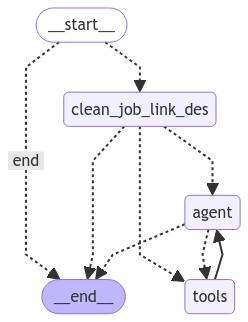

In [14]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [137]:
from pprint import pprint
inputs = {"messages": " summarize the job postings and send me mail"}
for output in graph.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation


"Node 'clean_job_link_des':"
'\n---\n'

"Node 'agent':"
'\n---\n'

"Node 'agent':"
'\n---\n'


InvalidUpdateError: Invalid update for channel summarized_text with values ['', '']

In [17]:
lenh()

NameError: name 'lenh' is not defined

In [ ]:
import requests
import feedparser
from bs4 import BeautifulSoup
import json
feed_url = 'https://www.upwork.com/ab/feed/topics/rss?securityToken=b02b265cc7370a516f799f0ad4322d3491cfc4c65c150e4bfd8bfbf76b64a7a9c200e84aaadb245e26951e0458fa14f3deb56524e7b5c6ffbf3f23489f7c7937&userUid=1648942861128376320&orgUid=1648942861128376321&topic=7610275'
response = requests.get(feed_url)
response.raise_for_status()
feed = feedparser.parse(response.content)
#last_entry_id = load_last_entry()
res=[]
for entry in feed.entries:       
    res.append(entry.id)
    soup = BeautifulSoup(entry.description, 'html.parser')
    tags=['br','b']
    for br in soup.find_all(tags):
        br.decompose()
    entry_link=entry.id
    Title=entry.title
    Link=entry.link
    Published=entry.published
    #new_last_entry_id=res[0]
    entry_description = soup.prettify()        
    print(Link)
    print(Title)
    print(entry_description)
    print("*"*100)
       

In [ ]:
import operator
from typing import Annotated, TypedDict

from langchain_core.pydantic_v1 import BaseModel
from langchain_anthropic import ChatAnthropic

from langgraph.constants import Send
from langgraph.graph import END, StateGraph, START

# Model and prompts
# Define model and prompts we will use
subjects_prompt = """Generate a comma separated list of between 2 and 5 examples related to: {topic}."""
joke_prompt = """Generate a joke about {subject}"""
best_joke_prompt = """Below are a bunch of jokes about {topic}. Select the best one! Return the ID of the best one.

{jokes}"""


class Subjects(BaseModel):
    subjects: list[str]


class Joke(BaseModel):
    joke: str


class BestJoke(BaseModel):
    id: int


model = ChatOpenAI(model="gpt-4o-mini")

# Graph components: define the components that will make up the graph


# This will be the overall state of the main graph.
# It will contain a topic (which we expect the user to provide)
# and then will generate a list of subjects, and then a joke for
# each subject
class OverallState(TypedDict):
    topic: str
    subjects: list
    # Notice here we use the operator.add
    # This is because we want combine all the jokes we generate
    # from individual nodes back into one list - this is essentially
    # the "reduce" part
    jokes: Annotated[list, operator.add]
    best_selected_joke: str


# This will be the state of the node that we will "map" all
# subjects to in order to generate a joke
class JokeState(TypedDict):
    subject: str


# This is the function we will use to generate the subjects of the jokes
def generate_topics(state: OverallState):
    prompt = subjects_prompt.format(topic=state["topic"])
    response = model.with_structured_output(Subjects).invoke(prompt)
    return {"subjects": response.subjects}


# Here we generate a joke, given a subject
def generate_joke(state: JokeState):
    prompt = joke_prompt.format(subject=state["subject"])
    response = model.with_structured_output(Joke).invoke(prompt)
    return {"jokes": [response.joke]}


# Here we define the logic to map out over the generated subjects
# We will use this an edge in the graph
def continue_to_jokes(state: OverallState):
    # We will return a list of `Send` objects
    # Each `Send` object consists of the name of a node in the graph
    # as well as the state to send to that node
    return [Send("generate_joke", {"subject": s}) for s in state["subjects"]]


# Here we will judge the best joke
def best_joke(state: OverallState):
    jokes = "\n\n".join(state["jokes"])
    prompt = best_joke_prompt.format(topic=state["topic"], jokes=jokes)
    response = model.with_structured_output(BestJoke).invoke(prompt)
    return {"best_selected_joke": state["jokes"][response.id]}


# Construct the graph: here we put everything together to construct our graph
graph = StateGraph(OverallState)
graph.add_node("generate_topics", generate_topics)
graph.add_node("generate_joke", generate_joke)
graph.add_node("best_joke", best_joke)
graph.add_edge(START, "generate_topics")
graph.add_conditional_edges("generate_topics", continue_to_jokes, ["generate_joke"])
graph.add_edge("generate_joke", "best_joke")
graph.add_edge("best_joke", END)
app = graph.compile()

In [ ]:
app.invoke({"topic":"animal"})

In [32]:
from langgraph.prebuilt import ToolInvocation
invocation = ToolInvocation(
    tool="mail_tool",
     tool_input="What is the capital of France?")

In [37]:
from langgraph.prebuilt.tool_executor import ToolExecutor, ToolInvocation
executor = ToolExecutor(all_tools)
invocation = ToolInvocation(tool="mail_tool", tool_input={"summarized_text":"hellow","published":"eett"})
result = executor.invoke(invocation)

In [ ]:
def tool_node(state:Single_docs):   
    executor = ToolExecutor(all_tools)
    invocation = ToolInvocation(tool="mail_tool", tool_input={"summarized_text":state['job_desc'],"published":state["job_pub"]})
    result = executor.invoke(invocation)

In [38]:
result

'Mail send to owner'

In [ ]:
class Single_docs(TypedDict):
    job_desc:str
    job_pub:str